有标签数据：100，无标签数据：9900
GMM对无标签数据的分类准确率：0.54


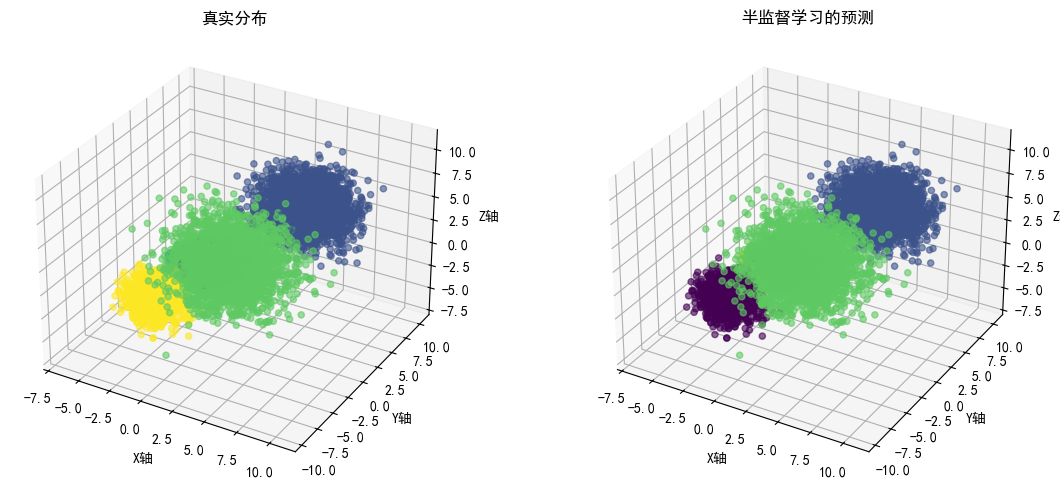

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'FangSong']  # 常用中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 数据集生成（高斯分布）
# X, y_true = make_blobs(n_samples=10000, centers=5, cluster_std=1.5, n_features=3)
# 定义每个类别的参数：中心点、方差、样本量
centers = [[0, 0, 0], [5, 5, 5], [-5, 5, -5], [3, -3, 3], [-3, -3, -3]]  # 5个三维中心点
cluster_std = [0.8, 1.5, 0.5, 2.0, 1.0]  # 每个类别的标准差不同
n_samples = [2000, 3000, 1000, 2500, 1500]    # 每个类别的样本量不同

# 生成数据
X, y_true = make_blobs(
    n_samples=n_samples,
    centers=centers,
    cluster_std=cluster_std,
    n_features=3
)

# 假吧意思模拟半监督的数据集，只让10%的数据有标签，无标签标记为-1
n_labeled = 100 # 有标签
indices = np.random.permutation(10000)
y = y_true.copy()
y[indices[n_labeled:]] = -1

print(f"有标签数据：{np.sum(y != -1)}，无标签数据：{np.sum(y == -1)}")

# 使用GMM+EM算法进行半监督学习
# 初始化GMM
gmm = GaussianMixture(n_components=5)

# 直接拟合所有数据，EM算法会自动隐式调用
gmm.fit(X)

# 预测所有数据
y_pred_gmm = gmm.predict(X)

# 评估准确性（对比无标签的）
mask_unlabeled = (y == -1)
accuracy = np.mean(y_pred_gmm[mask_unlabeled] == y_true[mask_unlabeled])
print(f"GMM对无标签数据的分类准确率：{accuracy:.2f}")

# 结果可视化
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_true, cmap='viridis', alpha=0.6)
ax1.set_title("真实分布")
ax1.set_xlabel("X轴")
ax1.set_ylabel("Y轴")
ax1.set_zlabel("Z轴")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred_gmm, cmap='viridis', alpha=0.6)
ax2.set_title("半监督学习的预测")
ax2.set_xlabel("X轴")
ax2.set_ylabel("Y轴")
ax2.set_zlabel("Z轴")

plt.tight_layout()
plt.show()

有标签样本数: 692, 无标签样本数: 6308
Iteration 1: 新增伪标签样本数: 5600
Iteration 2: 新增伪标签样本数: 448
Iteration 3: 新增伪标签样本数: 114
Iteration 4: 新增伪标签样本数: 29
Iteration 5: 新增伪标签样本数: 12
半监督 SVM 测试准确率: 0.95


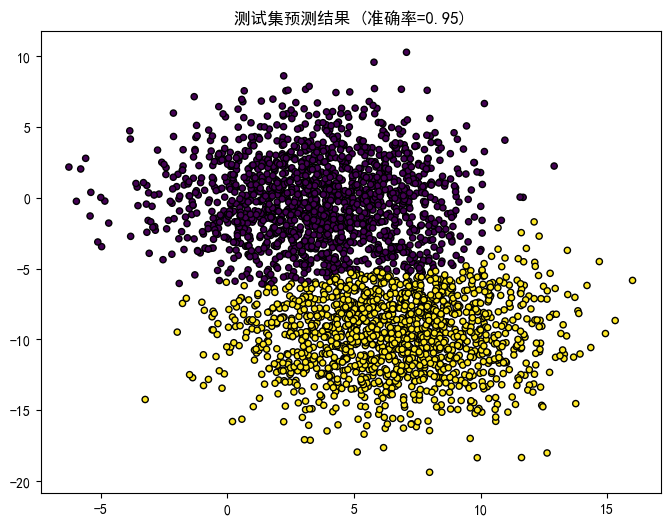

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 生成复杂数据（非线性可分，大标准差）
X, y_true = make_blobs(n_samples=10000, centers=2, cluster_std=3.0, random_state=99)

# 划分训练集（含未标注数据）和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.3, random_state=99)

# 在训练集中隐藏大部分标签（模拟半监督）
mask = np.random.rand(len(y_train)) < 0.1  # 只留10%训练数据有标签
X_labeled, y_labeled = X_train[mask], y_train[mask]
X_unlabeled = X_train[~mask]

print(f"有标签样本数: {len(X_labeled)}, 无标签样本数: {len(X_unlabeled)}")

# 半监督 SVM
s3vm = SVC(kernel='rbf', gamma='auto', probability=True, random_state=99)

for iteration in range(5):
    s3vm.fit(X_labeled, y_labeled)
    pseudo_labels = s3vm.predict(X_unlabeled)
    proba = s3vm.predict_proba(X_unlabeled)
    confidence = np.max(proba, axis=1)
    high_confidence = confidence > 0.9  # 通过置信度来进行每轮新增的伪标签筛选
    
    X_labeled = np.vstack([X_labeled, X_unlabeled[high_confidence]])
    y_labeled = np.hstack([y_labeled, pseudo_labels[high_confidence]])
    X_unlabeled = X_unlabeled[~high_confidence]
    
    print(f"Iteration {iteration + 1}: 新增伪标签样本数: {sum(high_confidence)}")

# 4. 用独立的测试集评估
y_pred = s3vm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"半监督 SVM 测试准确率: {accuracy:.2f}")

# 5. 可视化（仅展示测试集）
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=20, edgecolor='k')
plt.title(f"测试集预测结果 (准确率={accuracy:.2f})")
plt.show()

In [5]:
from sklearn.semi_supervised import LabelPropagation

# 随机数据
X = np.random.rand(500, 5)  # 特征矩阵
y = np.random.randint(0, 2, 500)  # 真实标签
y_mixed = np.where(np.random.rand(500) < 0.1, y, -1)  # 90%未标注（标注为-1）

# 标签传播模型
model = LabelPropagation(kernel='rbf', gamma=0.1) # gamma控制相似度衰减速度，越大下降越快
model.fit(X, y_mixed)

# 预测未标注数据
unlabeled_mask = (y_mixed == -1)
y_pred = model.predict(X[unlabeled_mask])
print("预测准确率:", (y_pred == y[unlabeled_mask]).mean())

预测准确率: 0.5340659340659341


In [13]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

# 1. 加载数据（20新闻组数据集）
categories = ['sci.med', 'sci.space']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)
X, y = newsgroups.data, newsgroups.target

# 2. 划分训练集（10%标注 + 90%未标注）和测试集
# 第一次划分：从全部数据中提取10%作为标注数据
X_labeled, X_remaining, y_labeled, y_remaining = train_test_split(
    X, y, train_size=0.1, random_state=42
)
# 第二次划分：从剩余数据中提取20%作为测试集
X_unlabeled, X_test, y_unlabeled, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42
)

# 3. 提取两个特征视图（模拟协同训练的条件独立假设）
# 视图1：TF-IDF特征（词频）
vectorizer_view1 = TfidfVectorizer(max_features=1000)
X_view1_labeled = vectorizer_view1.fit_transform(X_labeled)
X_view1_unlabeled = vectorizer_view1.transform(X_unlabeled)
X_view1_test = vectorizer_view1.transform(X_test)

# 视图2：词嵌入特征（模拟第二个视图）
vectorizer_view2 = TfidfVectorizer(max_features=500, ngram_range=(2, 2))
X_view2_labeled = vectorizer_view2.fit_transform(X_labeled)
X_view2_unlabeled = vectorizer_view2.transform(X_unlabeled)
X_view2_test = vectorizer_view2.transform(X_test)

# 4. 初始化两个协同训练的模型（不同视图）
model_view1 = RandomForestClassifier(n_estimators=50, random_state=42)
model_view2 = SVC(kernel='linear', probability=True, random_state=42)

# 5. 协同训练迭代
n_iterations = 3
for iteration in range(n_iterations):
    print(f"\n=== 迭代 {iteration + 1} ===")
    
    try:
        # 模型1在视图1上训练，并为视图2生成伪标签
        model_view1.fit(X_view1_labeled, y_labeled)
        proba_view2 = model_view1.predict_proba(X_view1_unlabeled)
        pseudo_labels_view2 = model_view1.predict(X_view1_unlabeled)
        confidence_mask_view2 = np.max(proba_view2, axis=1) > 0.9  # 仅高置信度样本
        
        # 模型2在视图2上训练，并为视图1生成伪标签
        model_view2.fit(X_view2_labeled, y_labeled)
        proba_view1 = model_view2.predict_proba(X_view2_unlabeled)
        pseudo_labels_view1 = model_view2.predict(X_view2_unlabeled)
        confidence_mask_view1 = np.max(proba_view1, axis=1) > 0.9
        
        # 检查是否有高置信度样本可用
        if not np.any(confidence_mask_view1) or not np.any(confidence_mask_view2):
            print("警告：没有高置信度样本可用于训练，跳过本轮迭代")
            continue
            
        # 互相扩充训练集（仅添加高置信度伪标签）
        # 确保添加的样本数量一致
        new_samples_view1 = X_view1_unlabeled[confidence_mask_view1]
        new_samples_view2 = X_view2_unlabeled[confidence_mask_view2]
        new_labels_view1 = pseudo_labels_view1[confidence_mask_view1]
        new_labels_view2 = pseudo_labels_view2[confidence_mask_view2]
        
        # 取两者中较小的样本量，保持对齐
        min_samples = min(new_samples_view1.shape[0], new_samples_view2.shape[0])
        if min_samples == 0:
            print("警告：没有共同的高置信度样本，跳过本轮迭代")
            continue
            
        # 添加相同数量的样本到两个视图
        X_view1_labeled = vstack([X_view1_labeled, new_samples_view1[:min_samples]])
        X_view2_labeled = vstack([X_view2_labeled, new_samples_view2[:min_samples]])
        y_labeled = np.concatenate([y_labeled, new_labels_view1[:min_samples]])
        
        # 转换为稀疏矩阵（节省内存）
        X_view1_labeled = csr_matrix(X_view1_labeled)
        X_view2_labeled = csr_matrix(X_view2_labeled)
        
        # 验证维度一致性
        assert X_view1_labeled.shape[0] == X_view2_labeled.shape[0] == len(y_labeled), \
            f"维度不一致！视图1: {X_view1_labeled.shape[0]}, 视图2: {X_view2_labeled.shape[0]}, 标签: {len(y_labeled)}"
        
        # 评估当前性能
        y_pred_view1 = model_view1.predict(X_view1_test)
        y_pred_view2 = model_view2.predict(X_view2_test)
        print(f"视图1模型测试准确率: {accuracy_score(y_test, y_pred_view1):.2f}")
        print(f"视图2模型测试准确率: {accuracy_score(y_test, y_pred_view2):.2f}")
        
    except Exception as e:
        print(f"迭代 {iteration + 1} 出错: {str(e)}")
        break

# 6. 最终模型集成（投票）
try:
    final_pred = np.where(
        model_view1.predict(X_view1_test) + model_view2.predict(X_view2_test) > 1,
        1, 0
    )
    print(f"\n协同训练最终投票准确率: {accuracy_score(y_test, final_pred):.2f}")
except Exception as e:
    print(f"最终投票出错: {str(e)}")


=== 迭代 1 ===
视图1模型测试准确率: 0.89
视图2模型测试准确率: 0.83

=== 迭代 2 ===
视图1模型测试准确率: 0.91
视图2模型测试准确率: 0.82

=== 迭代 3 ===
视图1模型测试准确率: 0.90
视图2模型测试准确率: 0.82

协同训练最终投票准确率: 0.85


In [42]:
from sklearn.metrics import pairwise_distances

"""约束K-Means算法"""
def constrained_kmeans(X, k, ml=None, cl=None, max_iter=100):
    """
    X : 数据矩阵 (n_samples, n_features)
    k : 簇数量
    ml : 必在同一簇的约束列表
    cl : 必不在同一簇的约束列表 
    max_iter : 最大迭代次数
    labels : 聚类结果标签
    """
    if cl is None:
        cl = []
    if ml is None:
        ml = []
    n_samples = X.shape[0]
    labels = -np.ones(n_samples, dtype=int)  # 用-1来表示未分配

    # 初始化中心（选择满足CL约束的样本）
    centers = X[np.random.choice(n_samples, k, replace=False)]
    
    for _ in range(max_iter):
        # 分配样本到簇
        for i in range(n_samples):
            distances = pairwise_distances(X[i].reshape(1, -1), centers).flatten()
            sorted_centers = np.argsort(distances)  # 按距离排序的簇索引
            
            # 检查约束
            allowed_centers = list(sorted_centers)
            for j in np.where(labels != -1)[0]:  # 遍历已分配的样本
                if (i, j) in ml or (j, i) in ml:
                    if labels[j] in allowed_centers:
                        allowed_centers = [labels[j]]  # 必须同簇
                    else:
                        allowed_centers = []  # 没有可行分配
                    break
                elif (i, j) in cl or (j, i) in cl:
                    allowed_centers = [c for c in allowed_centers if c != labels[j]]  # 禁选簇
            
            # 分配样本
            if allowed_centers:
                labels[i] = allowed_centers[0]  # 选择允许的最近簇
            else:
                labels[i] = -1  # 标记为噪声
        
        # 更新簇中心
        new_centers = np.zeros((k, X.shape[1]))
        for c in range(k):
            cluster_points = X[labels == c]
            if len(cluster_points) > 0:
                new_centers[c] = cluster_points.mean(axis=0)
            else:
                new_centers[c] = centers[c]  # 空簇保持原中心
        
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return labels


X = np.vstack([
    np.random.normal([0, 0], 0.5, size=(50, 2)),
    np.random.normal([8, 8], 0.5, size=(50, 2))
]) # 头尾相接合并随机产生的两个簇的数据

# 定义约束（索引对应X的行）
ml = [(0, 1), (6, 14), (28, 39)]    # 同簇
cl = [(0, 50), (4, 13), (25, 44)]  # 不能同簇

labels = constrained_kmeans(X, k=5, ml=ml, cl=cl)
print("约束K均值结果:", labels)

约束K均值结果: [4 4 3 2 2 3 2 4 3 3 2 3 3 3 2 3 4 4 4 4 2 2 2 2 2 3 4 4 2 4 2 3 2 4 2 2 4
 2 4 2 3 4 2 3 2 2 2 3 4 4 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1
 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1]


In [32]:
"""约束种子K-Means算法 """
def seeded_constrained_kmeans(X, k, seeds=None, ml=None, cl=None, max_iter=100):
    """
    seeds : 种子（分好类的数据）
    其余变量和没种子的方法里面的含义相同
    """
    if cl is None:
        cl = []
    if ml is None:
        ml = []
    if seeds is None:
        seeds = {}
    n_samples = X.shape[0]
    labels = -np.ones(n_samples, dtype=int)
    
    # 分配种子（分配分类）
    for idx, c in seeds.items():
        labels[idx] = c
    
    # 初始化中心
    centers = np.zeros((k, X.shape[1]))
    seed_classes = set(seeds.values()) if seeds else set()
    
    # 用种子样本计算初始中心
    for c in seed_classes:
        centers[c] = X[np.array([idx for idx, lbl in seeds.items() if lbl == c])].mean(axis=0)
    
    # 剩余中心随机初始化
    for c in range(k):
        if c not in seed_classes:
            centers[c] = X[np.random.choice(n_samples)]
    
    for _ in range(max_iter):
        # 分配样本到簇
        for i in range(n_samples):
            if i in seeds: # 种子不重新分配
                continue
                
            distances = pairwise_distances(X[i].reshape(1, -1), centers).flatten()
            sorted_centers = np.argsort(distances)
            
            # 检查约束
            allowed_centers = list(sorted_centers)
            for j in np.where(labels != -1)[0]:
                if (i, j) in ml or (j, i) in ml:
                    if labels[j] in allowed_centers:
                        allowed_centers = [labels[j]]
                    else:
                        allowed_centers = []
                    break
                elif (i, j) in cl or (j, i) in cl:
                    allowed_centers = [c for c in allowed_centers if c != labels[j]]
            
            if allowed_centers:
                labels[i] = allowed_centers[0]
        
        # 更新中心（不会修改种子中心）
        new_centers = centers.copy()
        for c in range(k):
            cluster_points = X[labels == c]
            if len(cluster_points) > 0 and c not in seed_classes:  # 不更新种子中心
                new_centers[c] = cluster_points.mean(axis=0)
        
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return labels

seeds = {0: 0, 50: 1, 24: 2, 14: 1, 42: 0}
labels_seeded = seeded_constrained_kmeans(X, k=5, seeds=seeds, ml=ml, cl=cl) # 直接用上一种方法实现里面定义好的数据以及两个限制条件
print("约束种子K均值结果:", labels_seeded)

约束种子K均值结果: [0 0 0 4 0 0 1 4 4 4 3 0 4 4 1 3 3 0 3 0 3 3 0 0 2 3 0 3 4 0 2 0 3 3 3 4 3
 0 3 4 0 3 0 4 0 4 4 3 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
